<a href="https://colab.research.google.com/github/hemantha-kumara/tensorflow-objectdetection/blob/master/Object_detection_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies installation

In [0]:
!pip install contextlib2 lxml pillow matplotlib Cython 

# Getting the Oxford-IIIT Pets Dataset and Uploading it to local /content path

In order to train a detector, we require a dataset of images, bounding boxes and classifications. For this demo, we'll use the Oxford-IIIT Pets dataset.  We will need to download both the image dataset images.tar.gz and the groundtruth data annotations.tar.gz to the tensorflow/models/research/ directory and unzip them. This may take some time.

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz  -P /content --no-check-certificate
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz  -P /content --no-check-certificate
%cd /content

!tar -C /content -xvf /content/images.tar.gz
!tar -C /content -xvf /content/annotations.tar.gz


# Downloading a COCO-pretrained Model for Transfer Learning
Training a state of the art object detector from scratch can take days, even when using multiple GPUs! In order to speed up training, we'll take an object detector trained on a different dataset (COCO), and reuse some of it's parameters to initialize our new model.

Download our COCO-pretrained Faster R-CNN with Resnet-101 model. Unzip the contents of the folder and copy the model.ckpt* files into your /content

In [0]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz  -P /content --no-check-certificate
!tar -C /content -xvf /content/faster_rcnn_resnet101_coco_2018_01_28.tar.gz

In [0]:
!mkdir /content/code
!git clone https://github.com/tensorflow/models.git /content/code
%cd /content/code
!git checkout 81123eb

# Protobuf Compilation
The Tensorflow Object Detection API uses Protobufs to configure model and training parameters. Before the framework can be used, the Protobuf libraries must be compiled. This should be done by running the following command from the tensorflow/models/research/ directory:

In [0]:
%cd /content/code/research
!wget https://github.com/google/protobuf/releases/download/v3.0.0/protoc-3.0.0-linux-x86_64.zip
!unzip protoc-3.0.0-linux-x86_64.zip
!./bin/protoc object_detection/protos/*.proto --python_out=.


# Add Libraries to PYTHONPATH
When running locally, the tensorflow/models/research/ and slim directories should be appended to PYTHONPATH. This can be done by running the following from models/research/

In [0]:
!export PYTHONPATH=$PYTHONPATH:/content/code/research:/content/code/research/slim
%cd /content/code/research/
!python setup.py build
!python setup.py install
%cd /content/code/research/slim
!pip install -e .

# Creation of TFRecords
The Tensorflow Object Detection API expects data to be in the TFRecord format, so we'll now run the create_pet_tf_record script to convert from the raw Oxford-IIIT Pet dataset into TFRecords.

In [0]:
!python /content/code/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=/content/code/research/object_detection/data/pet_label_map.pbtxt --data_dir=/content --output_dir=/content

# Starting Tensorflow Training

In [0]:
!python /content/code/research/object_detection/legacy/train.py --pipeline_config_path=/content/faster_rcnn_resnet101_pets.config --train_dir=/content/train

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






Instructions for updating:
Use object_detection/model_main.py.
W0916 14:36:55.924364 139651553335168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/absl/app.py:250: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.

W0916 14:36:55.924587 139651553335168 deprecation_wrapper.py:119] From /content/code/research/object_detection/legacy/train.py:90: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0916 14:36:55.924930 139651553335168 deprecation_wrapper.py:119] From /usr/local/lib/python3

# Exporting the Tensorflow Graph
After your model has been trained, you should export it to a Tensorflow graph proto. First, you need to identify a candidate checkpoint to export.
checkpoint files can be found in /content/train/
The checkpoint will typically consist of three files:
```
model.ckpt-${CHECKPOINT_NUMBER}.data-00000-of-00001
model.ckpt-${CHECKPOINT_NUMBER}.index
model.ckpt-${CHECKPOINT_NUMBER}.meta
```

In [0]:
%env CHECKPOINT_NUMBER=99
!python /content/code/research/object_detection/export_inference_graph.py --input_type=image_tensor --pipeline_config_path=/content/faster_rcnn_resnet101_pets.config --trained_checkpoint_prefix=/content/train/model.ckpt-${CHECKPOINT_NUMBER} --output_directory=/content/exported_graphs

In [102]:
#!tensorboard --logdir=file:///content/exported_graphs/
LOG_DIR = 'file:///content/exported_graphs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.2
updated 1 package in 1.96s
your url is: https://thin-moose-98.localtunnel.me
your url is: https://curly-fish-33.localtunnel.me


# object detection inference

**imports**

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


# Env setup

In [0]:
# This is needed to display the images.
%matplotlib inline

# Object detection imports
Here are the imports from the object detection module

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Model preparation
Any model exported using the export_inference_graph.py tool can be loaded here simply by changing PATH_TO_FROZEN_GRAPH to point to a new .pb file.

In [0]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/content/exported_graphs/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/code/research/object_detection/data/pet_label_map.pbtxt'

# Load a (frozen) Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loading label map
Label maps map indices to category names, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Helper github for images ex

In [0]:
!mkdir /content/final_inference_code
!git clone https://github.com/kubeflow/examples.git /content/final_inference_code

# Detection

In [0]:
# For the sake of simplicity we will use only 1 image:
TEST_IMAGE_PATHS = ['/content/final_inference_code/object_detection/serving_script/image1.jpg']
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

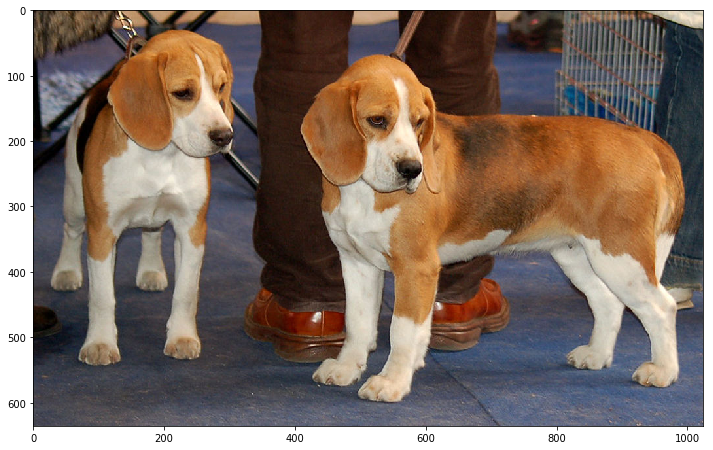

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()

In [84]:
from google.colab import drive
drive.mount('/dataDrive/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /dataDrive/drive


In [0]:
%mkdir /dataDrive/drive/My\ Drive/colab

In [0]:
from distutils.dir_util import copy_tree
# copy subdirectory example
fromDirectory = "/content/"
toDirectory = "/dataDrive/drive/My Drive/colab/"

copy_tree(fromDirectory, toDirectory)

In [0]:
import shutil
shutil.rmtree('/content/annotations')

In [0]:
import shutil
shutil.rmtree('/content/images')

In [0]:
import os
os.remove('/content/annotations.tar.gz')

In [0]:
import os
os.remove('/content/images.tar.gz')